# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные зхначения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

--------------------------------------------

In [47]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [49]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [50]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [51]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [52]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

# Альтернативный вариант - переименовываем столбцы перед соединением
# combined = all_aggs[0]
# for agg in all_aggs[1:]:
#     # Переименовываем все столбцы кроме user_id
#     cols_to_rename = [col for col in agg.columns if col != 'user_id']
#     agg = agg.rename({col: f"{col}_new" for col in cols_to_rename})
#     combined = combined.join(agg, on='user_id', how='outer')

# Функция для создания полиномиальных фичей с исправлением
def add_polynomial_features(df, features, degree=2):
    """
    Добавляет полиномиальные комбинации фичей до указанной степени
    """
    # Создаем копию датафрейма для модификации
    result_df = df.clone()
    
    # Создаем все комбинации фичей для полиномов
    for feat1, feat2 in combinations(features, 2):
        # Умножение фичей (взаимодействие)
        result_df = result_df.with_columns(
            (pl.col(feat1) * pl.col(feat2)).alias(f'{feat1}_x_{feat2}')
        )
        
        # Можно добавить другие степени при необходимости
        if degree > 2:
            result_df = result_df.with_columns(
                (pl.col(feat1)**2 * pl.col(feat2)).alias(f'{feat1}^2_x_{feat2}'),
                (pl.col(feat1) * pl.col(feat2)**2).alias(f'{feat1}_x_{feat2}^2')
            )
    
    # Добавляем квадраты фичей
    for feat in features:
        result_df = result_df.with_columns(
            (pl.col(feat)**2).alias(f'{feat}^2')
        )
        if degree > 2:
            result_df = result_df.with_columns((pl.col(feat)**3).alias(f'{feat}^3'))
    
    return result_df

# Добавляем полиномиальные фичи 2-й степени
try:
    combined_with_poly = add_polynomial_features(combined, numeric_features, degree=2)
except Exception as e:
    print(f"Ошибка при создании полиномиальных фичей: {e}")
    # Выводим список столбцов для отладки
    print("Доступные столбцы:", combined.columns)
    print("Числовые фичи для полиномов:", numeric_features)
    # Фильтруем только существующие фичи
    existing_features = [f for f in numeric_features if f in combined.columns]
    print("Существующие числовые фичи:", existing_features)
    combined_with_poly = add_polynomial_features(combined, existing_features, degree=2)

In [53]:
combined_with_poly

user_id,num_products_click,sum_discount_price_click,max_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,num_products_favorite,sum_discount_price_favorite,max_discount_price_favorite,last_favorite_time,first_favorite_time,days_since_last_favorite,days_since_first_favorite,num_products_order,sum_discount_price_order,max_discount_price_order,last_order_time,first_order_time,days_since_last_order,days_since_first_order,num_products_to_cart,sum_discount_price_to_cart,max_discount_price_to_cart,last_to_cart_time,first_to_cart_time,days_since_last_to_cart,days_since_first_to_cart,num_products_click_x_sum_discount_price_click,num_products_click_x_max_discount_price_click,num_products_click_x_days_since_last_click,num_products_click_x_days_since_first_click,num_products_click_x_num_products_favorite,num_products_click_x_sum_discount_price_favorite,num_products_click_x_max_discount_price_favorite,num_products_click_x_days_since_last_favorite,…,days_since_last_order_x_days_since_last_to_cart,days_since_last_order_x_days_since_first_to_cart,days_since_first_order_x_num_products_to_cart,days_since_first_order_x_sum_discount_price_to_cart,days_since_first_order_x_max_discount_price_to_cart,days_since_first_order_x_days_since_last_to_cart,days_since_first_order_x_days_since_first_to_cart,num_products_to_cart_x_sum_discount_price_to_cart,num_products_to_cart_x_max_discount_price_to_cart,num_products_to_cart_x_days_since_last_to_cart,num_products_to_cart_x_days_since_first_to_cart,sum_discount_price_to_cart_x_max_discount_price_to_cart,sum_discount_price_to_cart_x_days_since_last_to_cart,sum_discount_price_to_cart_x_days_since_first_to_cart,max_discount_price_to_cart_x_days_since_last_to_cart,max_discount_price_to_cart_x_days_since_first_to_cart,days_since_last_to_cart_x_days_since_first_to_cart,num_products_click^2,sum_discount_price_click^2,max_discount_price_click^2,days_since_last_click^2,days_since_first_click^2,num_products_favorite^2,sum_discount_price_favorite^2,max_discount_price_favorite^2,days_since_last_favorite^2,days_since_first_favorite^2,num_products_order^2,sum_discount_price_order^2,max_discount_price_order^2,days_since_last_order^2,days_since_first_order^2,num_products_to_cart^2,sum_discount_price_to_cart^2,max_discount_price_to_cart^2,days_since_last_to_cart^2,days_since_first_to_cart^2
i32,i32,f32,f32,datetime[ns],datetime[ns],i32,i32,i32,f32,f32,datetime[ns],datetime[ns],i32,i32,i32,f32,f32,datetime[ns],datetime[ns],i32,i32,i32,f32,f32,datetime[ns],datetime[ns],i32,i32,f64,f64,i32,i32,i32,f64,f64,i32,…,i32,i32,i32,f64,f64,i32,i32,f64,f64,i32,i32,f32,f64,f64,f64,f64,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32
2663183,2,1394.0,828.0,2024-05-12 14:21:45,2024-05-12 14:21:34,49,49,null,null,null,null,null,null,null,2,962.0,949.0,2024-05-12 14:21:23,2024-05-12 14:21:23,49,49,1,828.0,828.0,2024-05-12 14:21:53,2024-05-12 14:21:53,49,49,2788.0,1656.0,98,98,null,null,null,null,…,2401,2401,49,40572.0,40572.0,2401,2401,828.0,828.0,49,49,685584.0,40572.0,40572.0,40572.0,40572.0,2401,4,1.943236e6,685584.0,2401,2401,null,null,null,null,null,4,925444.0,900601.0,2401,2401,1,685584.0,685584.0,2401,2401
6051052,1,352.0,352.0,2024-05-28 20:53:13,2024-05-28 20:53:13,33,33,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,352.0,352.0,33,33,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,123904.0,123904.0,1089,1089,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
9113346,1,171.0,171.0,2024-06-25 04:28:52,2024-06-25 04:28:52,5,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,171.0,171.0,5,5,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,29241.0,29241.0,25,25,null,null,null,null,null,null,null,null,n

In [54]:
# search_aggs
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),
        
        # Временные метки
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',                # Всего поисков за 5 месяцев
        f'num_{suf}_last_month',     # Поисков за последний месяц
        f'num_{suf}_last_week',      # Поисков за последнюю неделю
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [55]:
df = val_target
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [56]:
df_pd = df.to_pandas()

In [57]:
df_pd = df_pd[df_pd['user_id'] != 2346229]

In [58]:
tr, val = get_split(df_pd, val_size=0.3)

In [59]:
cols = [
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search'
]

In [60]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453208, number of negative: 859260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4421
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 23
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345310 -> initscore=-0.639720
[LightGBM] [Info] Start training from score -0.639720
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [2068  622  549  626  371  476   75  324  201  270 1311 1458  722 1652
 2152 1405 1248  692  856  927 1314  787  864] 



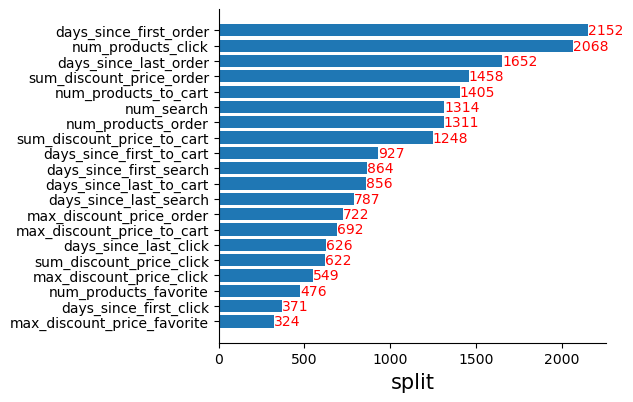

In [61]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=20, sklearn_style=True)

In [62]:
test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [70]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

# Функция для добавления полиномиальных фичей (такая же как для трейна)
def add_polynomial_features(df, features, degree=2):
    """
    Добавляет полиномиальные комбинации фичей до указанной степени
    """
    # Создаем копию датафрейма для модификации
    result_df = df.clone()
    
    # Создаем все комбинации фичей для полиномов
    for feat1, feat2 in combinations(features, 2):
        # Умножение фичей (взаимодействие)
        result_df = result_df.with_columns(
            (pl.col(feat1) * pl.col(feat2)).alias(f'{feat1}_x_{feat2}')
        )
        
        # Можно добавить другие степени при необходимости
        if degree > 2:
            result_df = result_df.with_columns(
                (pl.col(feat1)**2 * pl.col(feat2)).alias(f'{feat1}^2_x_{feat2}'),
                (pl.col(feat1) * pl.col(feat2)**2).alias(f'{feat1}_x_{feat2}^2')
            )
    
    # Добавляем квадраты фичей
    for feat in features:
        result_df = result_df.with_columns(
            (pl.col(feat)**2).alias(f'{feat}^2')
        )
        if degree > 2:
            result_df = result_df.with_columns(
                (pl.col(feat)**3).alias(f'{feat}^3')
            )
    
    return result_df

# Добавляем полиномиальные фичи к валидационной выборке
# Используем только существующие фичи
existing_features = [f for f in numeric_features if f in combined_val.columns]
combined_val_with_poly = add_polynomial_features(combined_val, existing_features, degree=2)

C:\Users\Admin\AppData\Local\Temp\ipykernel_32712\263249201.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [71]:
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),
        
        # Временные метки
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',                # Всего поисков за 5 месяцев
        f'num_{suf}_last_month',     # Поисков за последний месяц
        f'num_{suf}_last_week',      # Поисков за последнюю неделю
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [72]:
df = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [73]:
df_pd = df.to_pandas()

In [74]:
df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

In [75]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.159223
1,9852,0.758693
2,10206,0.217444
3,11317,0.215378
4,13289,0.578743
...,...,...
2068419,11157283,0.223528
2068420,11160395,0.148461
2068421,11165052,0.591139
2068422,11168218,0.482935


In [77]:
df_pd[['user_id', 'predict']].to_csv('res.csv', index=False)